In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import yfinance as yf

warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Bitcoin Trading Performance vs Market Sentiment Analysis")
print("=" * 60)

📊 Bitcoin Trading Performance vs Market Sentiment Analysis


In [69]:
# 1. DATA LOADING AND PREPROCESSING
# =============================================================================

def load_and_preprocess_data():
    """Load and preprocess both datasets"""

    print("🔄 Loading datasets...")

    # Load historical trading data
    try:
        historical_data = pd.read_csv('historical_data.csv')
        print(f"✅ Historical data loaded: {historical_data.shape[0]} rows, {historical_data.shape[1]} columns")
    except FileNotFoundError:
        print("❌ historical_data.csv not found. Please upload the file.")
        return None, None

    # Load sentiment data
    try:
        sentiment_data = pd.read_csv('fear_greed_index.csv')
        print(f"✅ Sentiment data loaded: {sentiment_data.shape[0]} rows, {sentiment_data.shape[1]} columns")
    except FileNotFoundError:
        print("❌ fear_greed_index.csv not found. Please upload the file.")
        return None, None

    # Preprocess historical data
    print("\n🔧 Preprocessing historical data...")
    # Handle different datetime formats - try multiple formats
    try:
        # First try with dayfirst=True for DD-MM-YYYY format
        historical_data['Timestamp IST'] = pd.to_datetime(historical_data['Timestamp IST'], dayfirst=True)
    except:
        try:
            # Try with mixed format inference
            historical_data['Timestamp IST'] = pd.to_datetime(historical_data['Timestamp IST'], format='mixed')
        except:
            # Try with infer_datetime_format
            historical_data['Timestamp IST'] = pd.to_datetime(historical_data['Timestamp IST'], infer_datetime_format=True)

    historical_data['Date'] = historical_data['Timestamp IST'].dt.date
    historical_data['Hour'] = historical_data['Timestamp IST'].dt.hour

    # Convert PnL to numeric
    historical_data['Closed PnL'] = pd.to_numeric(historical_data['Closed PnL'], errors='coerce')
    historical_data['Size USD'] = pd.to_numeric(historical_data['Size USD'], errors='coerce')
    historical_data['Execution Price'] = pd.to_numeric(historical_data['Execution Price'], errors='coerce')

    # Create profit/loss categories
    historical_data['PnL_Category'] = historical_data['Closed PnL'].apply(
        lambda x: 'Profit' if x > 0 else ('Loss' if x < 0 else 'Breakeven')
    )

    # Preprocess sentiment data
    print("🔧 Preprocessing sentiment data...")
    sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])
    sentiment_data['Date'] = sentiment_data['date'].dt.date

    # Create sentiment categories
    def categorize_sentiment(value, classification):
        if classification in ['Extreme Fear']:
            return 'Extreme Fear'
        elif classification == 'Fear':
            return 'Fear'
        elif classification == 'Neutral':
            return 'Neutral'
        elif classification == 'Greed':
            return 'Greed'
        else:
            return 'Unknown'

    sentiment_data['Sentiment_Category'] = sentiment_data.apply(
        lambda row: categorize_sentiment(row['value'], row['classification']), axis=1
    )

    print(f"📅 Historical data date range: {historical_data['Date'].min()} to {historical_data['Date'].max()}")
    print(f"📅 Sentiment data date range: {sentiment_data['Date'].min()} to {sentiment_data['Date'].max()}")

    return historical_data, sentiment_data
historical_data, sentiment_data = load_and_preprocess_data()

🔄 Loading datasets...
✅ Historical data loaded: 211224 rows, 16 columns
✅ Sentiment data loaded: 2644 rows, 4 columns

🔧 Preprocessing historical data...
🔧 Preprocessing sentiment data...
📅 Historical data date range: 2023-05-01 to 2025-05-01
📅 Sentiment data date range: 2018-02-01 to 2025-05-02



📈 EXPLORATORY DATA ANALYSIS

📊 Historical Trading Data Overview:
       Execution Price   Size Tokens      Size USD  \
count    211224.000000  2.112240e+05  2.112240e+05   
mean      11414.723350  4.623365e+03  5.639451e+03   
min           0.000005  8.740000e-07  0.000000e+00   
25%           4.854700  2.940000e+00  1.937900e+02   
50%          18.280000  3.200000e+01  5.970450e+02   
75%         101.580000  1.879025e+02  2.058960e+03   
max      109004.000000  1.582244e+07  3.921431e+06   
std       29447.654868  1.042729e+05  3.657514e+04   

                       Timestamp IST  Start Position     Closed PnL  \
count                         211224    2.112240e+05  211224.000000   
mean   2025-01-31 12:04:22.915009792   -2.994625e+04      48.749001   
min              2023-05-01 01:06:00   -1.433463e+07 -117990.104100   
25%              2024-12-31 21:00:45   -3.762311e+02       0.000000   
50%              2025-02-24 18:55:00    8.472793e+01       0.000000   
75%              2025

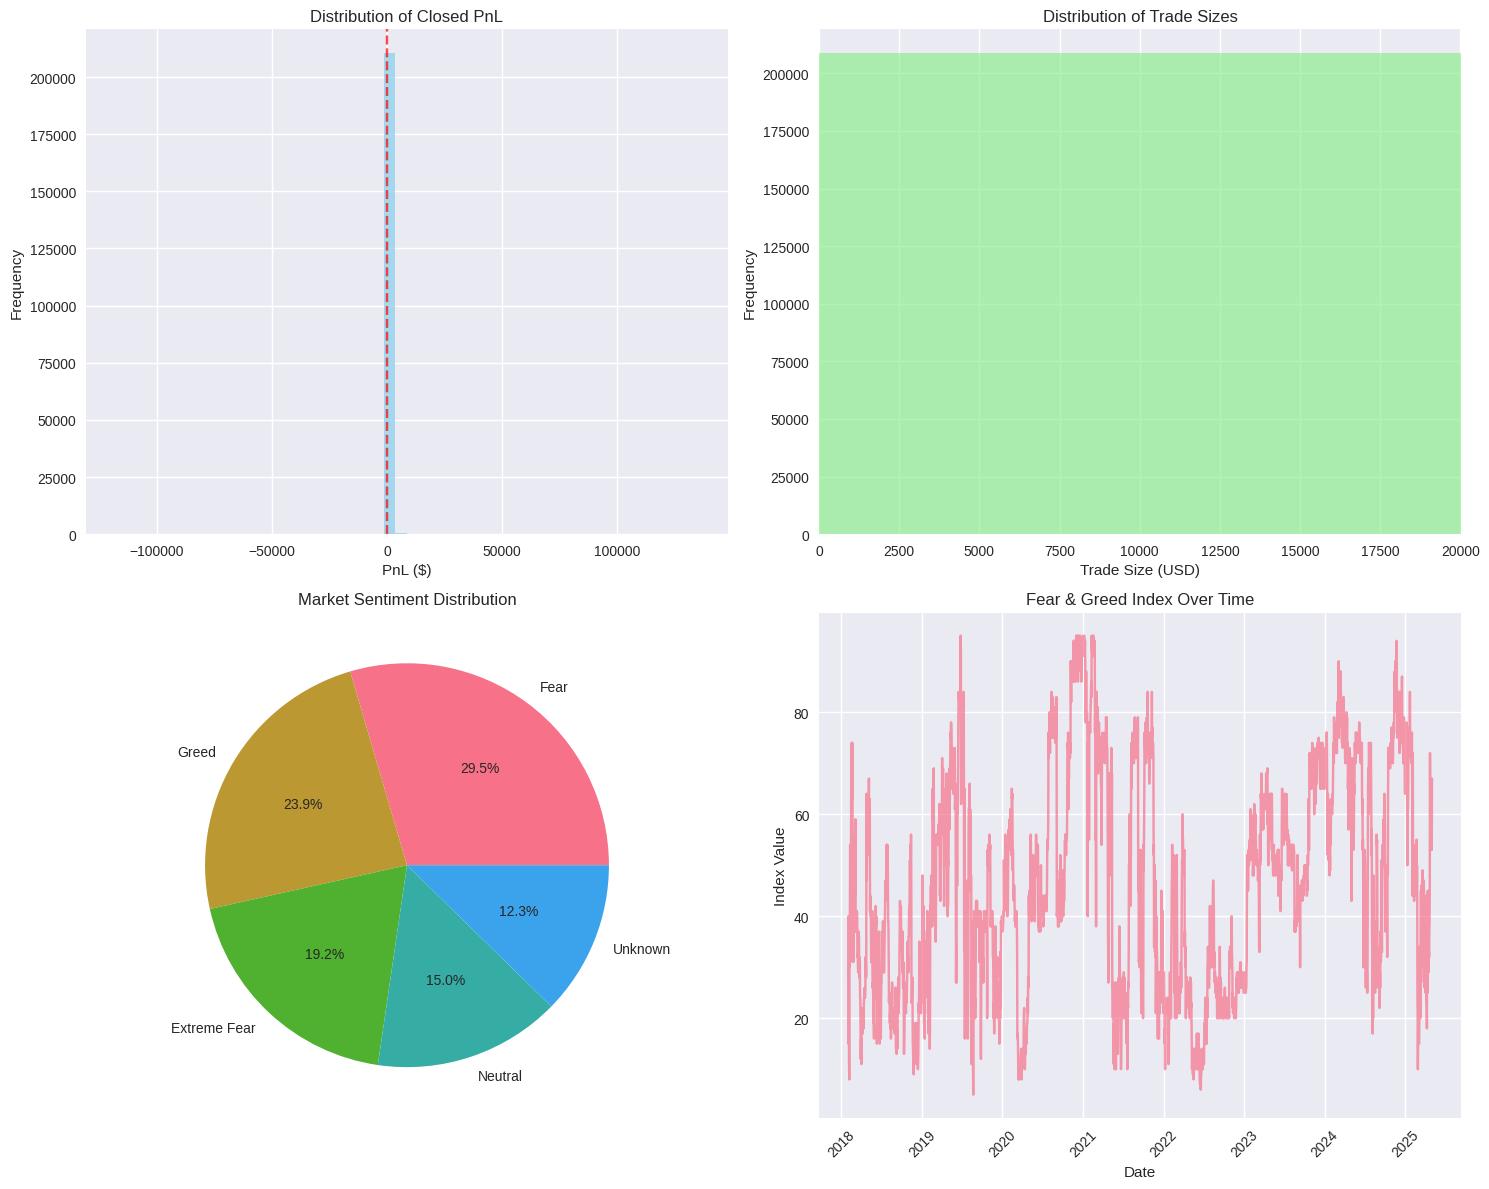

In [70]:
# 2. EXPLORATORY DATA ANALYSIS
# =============================================================================

def perform_eda(historical_data, sentiment_data):
    """Perform comprehensive exploratory data analysis"""

    print("\n" + "="*60)
    print("📈 EXPLORATORY DATA ANALYSIS")
    print("="*60)

    # Historical data overview
    print("\n📊 Historical Trading Data Overview:")
    print(historical_data.describe())
    print(f"\nTotal Trades: {len(historical_data)}")
    print(f"Unique Traders: {historical_data['Account'].nunique()}")
    print(f"Total PnL: ${historical_data['Closed PnL'].sum():.2f}")
    print(f"Average Trade Size: ${historical_data['Size USD'].mean():.2f}")

    # Sentiment data overview
    print("\n📊 Sentiment Data Overview:")
    print(sentiment_data['Sentiment_Category'].value_counts())
    print(f"Average Fear & Greed Index: {sentiment_data['value'].mean():.2f}")

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. PnL Distribution
    axes[0, 0].hist(historical_data['Closed PnL'], bins=50, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution of Closed PnL')
    axes[0, 0].set_xlabel('PnL ($)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.7)

    # 2. Trade Size Distribution
    axes[0, 1].hist(historical_data['Size USD'], bins=50, alpha=0.7, color='lightgreen')
    axes[0, 1].set_title('Distribution of Trade Sizes')
    axes[0, 1].set_xlabel('Trade Size (USD)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_xlim(0, historical_data['Size USD'].quantile(0.95))

    # 3. Sentiment Distribution
    sentiment_counts = sentiment_data['Sentiment_Category'].value_counts()
    axes[1, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
    axes[1, 0].set_title('Market Sentiment Distribution')

    # 4. Fear & Greed Index Over Time
    axes[1, 1].plot(sentiment_data['date'], sentiment_data['value'], alpha=0.7)
    axes[1, 1].set_title('Fear & Greed Index Over Time')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Index Value')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
perform_eda(historical_data, sentiment_data)


🔗 MERGING DATA AND CORRELATION ANALYSIS
✅ Merged dataset created: 211218 records
📅 Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00


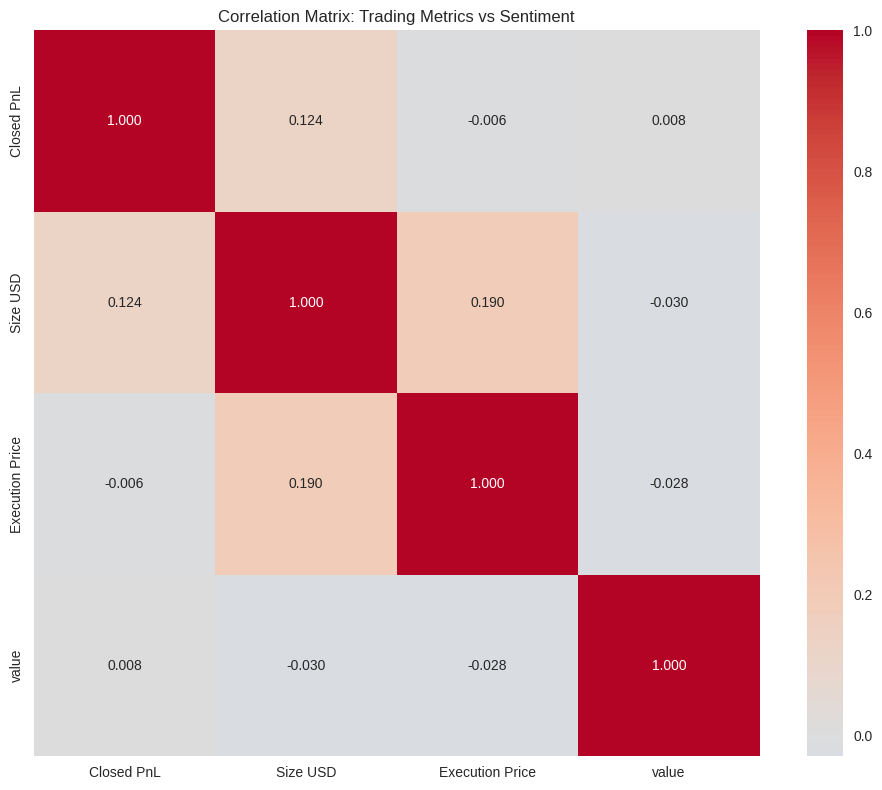

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Order ID,Crossed,Fee,Trade ID,Timestamp,Date,Hour,PnL_Category,value,Sentiment_Category
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0000,...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,22,Breakeven,80,Unknown
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0000,...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,22,Breakeven,80,Unknown
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0000,...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,22,Breakeven,80,Unknown
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0000,...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,22,Breakeven,80,Unknown
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0000,...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,22,Breakeven,80,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211213,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.1010,382.20,420.80,SELL,2025-04-25 15:35:00,7546.600000,Close Long,-20.2566,...,88803313862,False,0.042080,1.990000e+14,1.750000e+12,2025-04-25,15,Loss,60,Greed
211214,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.1010,2124.10,2338.63,SELL,2025-04-25 15:35:00,7164.400000,Close Long,-112.5773,...,88803313862,False,0.233863,9.260000e+14,1.750000e+12,2025-04-25,15,Loss,60,Greed
211215,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.1010,423.40,466.16,SELL,2025-04-25 15:35:00,5040.300000,Close Long,-22.4402,...,88803313862,False,0.046616,6.930000e+14,1.750000e+12,2025-04-25,15,Loss,60,Greed
211216,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.1010,3599.80,3963.38,SELL,2025-04-25 15:35:00,4616.900000,Close Long,-190.7894,...,88803313862,False,0.396337,4.180000e+14,1.750000e+12,2025-04-25,15,Loss,60,Greed


In [71]:
# 3. MERGE DATA AND ANALYZE CORRELATIONS
# =============================================================================

def merge_and_analyze(historical_data, sentiment_data):
    """Merge datasets and analyze correlations"""

    print("\n" + "="*60)
    print("🔗 MERGING DATA AND CORRELATION ANALYSIS")
    print("="*60)

    # Convert Date columns to the same type for merging
    historical_data['Date'] = pd.to_datetime(historical_data['Date'])
    sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])

    # Merge datasets
    merged_data = historical_data.merge(sentiment_data[['Date', 'value', 'Sentiment_Category']],
                                       on='Date', how='inner')

    print(f"✅ Merged dataset created: {len(merged_data)} records")
    print(f"📅 Date range: {merged_data['Date'].min()} to {merged_data['Date'].max()}")

    # Analyze correlations
    correlation_matrix = merged_data[['Closed PnL', 'Size USD', 'Execution Price', 'value']].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f')
    plt.title('Correlation Matrix: Trading Metrics vs Sentiment')
    plt.tight_layout()
    plt.show()

    return merged_data

merge_and_analyze(historical_data, sentiment_data)


💰 SENTIMENT-BASED PERFORMANCE ANALYSIS
📊 Performance by Sentiment Category:
                   Closed PnL                                    Size USD  \
                        count         sum   mean median      std     mean   
Sentiment_Category                                                          
Extreme Fear            21400   739110.25  34.54    0.0  1136.06  5349.73   
Fear                    61837  3357155.44  54.29    0.0   935.36  7816.11   
Greed                   50303  2150129.27  42.74    0.0  1116.03  5736.88   
Neutral                 37686  1292920.68  34.31    0.0   517.12  4782.73   
Unknown                 39992  2715171.31  67.89    0.0   766.83  3112.25   

                            value        
                    median   mean   std  
Sentiment_Category                       
Extreme Fear        766.15  19.69  3.58  
Fear                735.96  33.20  6.35  
Greed               555.00  67.98  5.80  
Neutral             547.66  48.66  2.48  
Unknown     

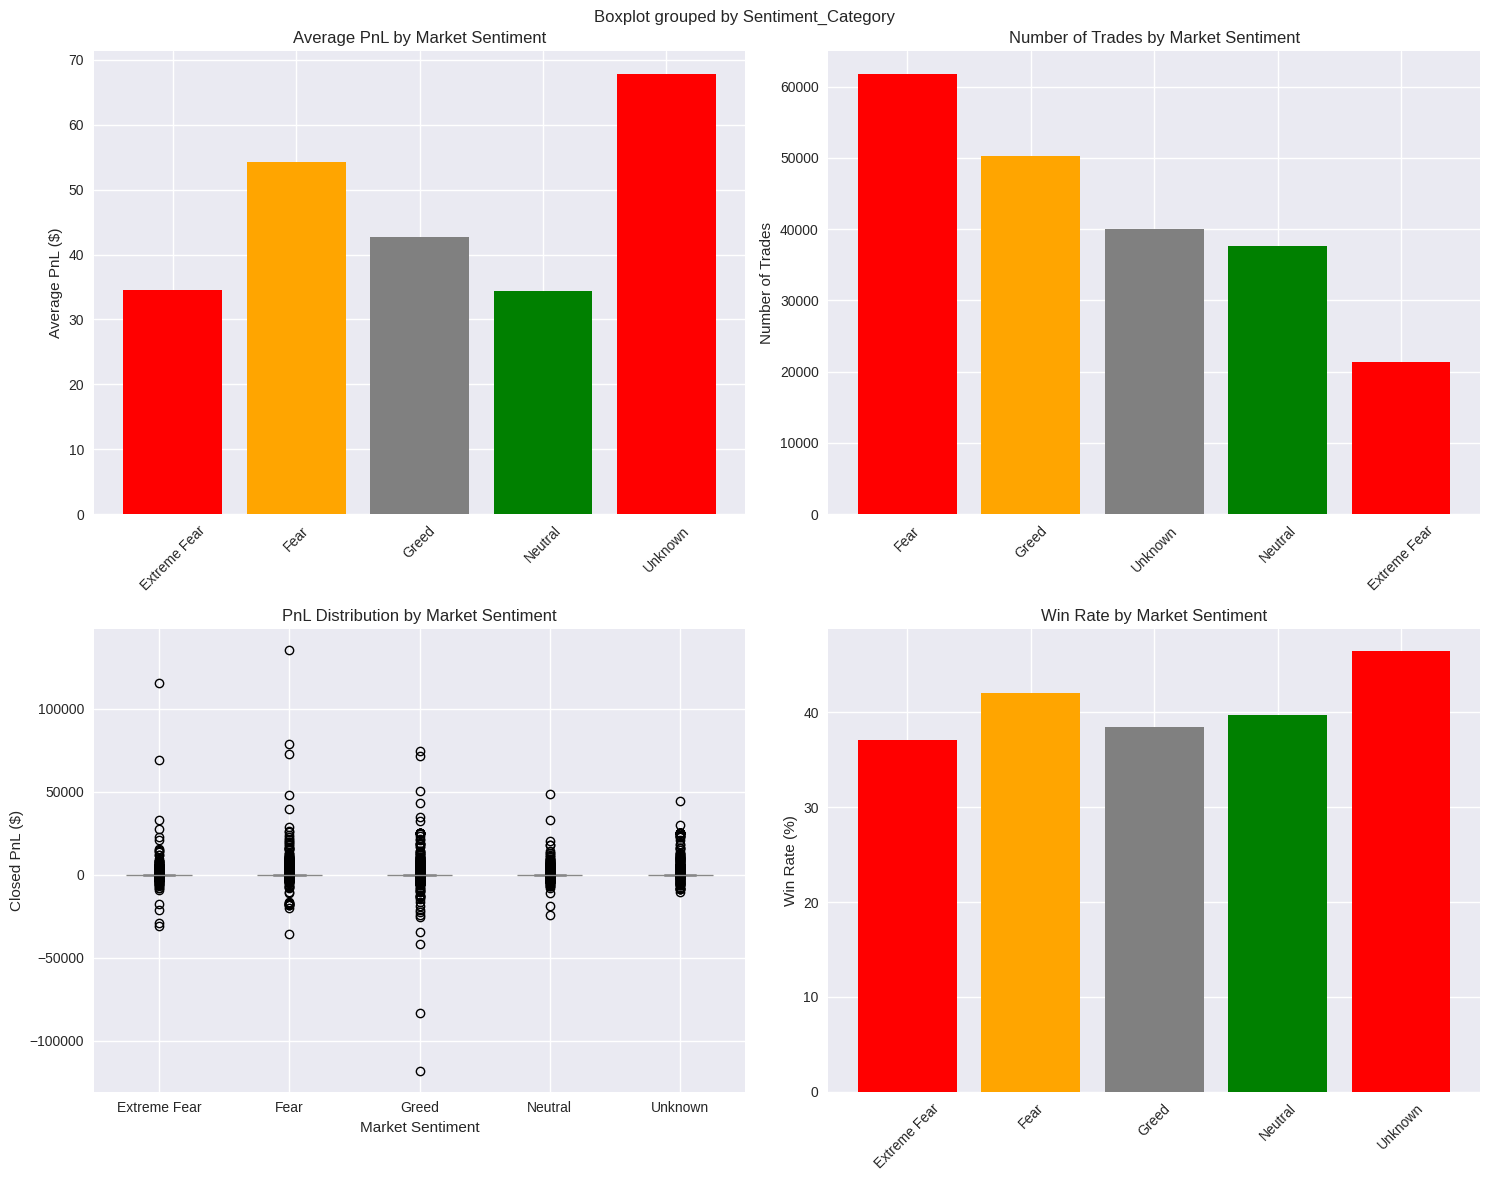

In [72]:
# 4. SENTIMENT-BASED TRADING PERFORMANCE ANALYSIS
# =============================================================================

def analyze_sentiment_performance(merged_data):
    """Analyze trading performance across different sentiment levels"""

    print("\n" + "="*60)
    print("💰 SENTIMENT-BASED PERFORMANCE ANALYSIS")
    print("="*60)

    # Group by sentiment category
    sentiment_performance = merged_data.groupby('Sentiment_Category').agg({
        'Closed PnL': ['count', 'sum', 'mean', 'median', 'std'],
        'Size USD': ['mean', 'median'],
        'value': ['mean', 'std']
    }).round(2)

    print("📊 Performance by Sentiment Category:")
    print(sentiment_performance)

    # Calculate win rates
    def calculate_win_rate(group):
        return (group['Closed PnL'] > 0).mean() * 100

    win_rates = merged_data.groupby('Sentiment_Category').apply(calculate_win_rate)
    print(f"\n🎯 Win Rates by Sentiment:")
    for sentiment, rate in win_rates.items():
        print(f"{sentiment}: {rate:.1f}%")

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Average PnL by Sentiment
    avg_pnl = merged_data.groupby('Sentiment_Category')['Closed PnL'].mean()
    axes[0, 0].bar(avg_pnl.index, avg_pnl.values, color=['red', 'orange', 'gray', 'green'])
    axes[0, 0].set_title('Average PnL by Market Sentiment')
    axes[0, 0].set_ylabel('Average PnL ($)')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Trade Count by Sentiment
    trade_counts = merged_data['Sentiment_Category'].value_counts()
    axes[0, 1].bar(trade_counts.index, trade_counts.values, color=['red', 'orange', 'gray', 'green'])
    axes[0, 1].set_title('Number of Trades by Market Sentiment')
    axes[0, 1].set_ylabel('Number of Trades')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. PnL Distribution by Sentiment
    merged_data.boxplot(column='Closed PnL', by='Sentiment_Category', ax=axes[1, 0])
    axes[1, 0].set_title('PnL Distribution by Market Sentiment')
    axes[1, 0].set_xlabel('Market Sentiment')
    axes[1, 0].set_ylabel('Closed PnL ($)')

    # 4. Win Rate by Sentiment
    axes[1, 1].bar(win_rates.index, win_rates.values, color=['red', 'orange', 'gray', 'green'])
    axes[1, 1].set_title('Win Rate by Market Sentiment')
    axes[1, 1].set_ylabel('Win Rate (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return sentiment_performance, win_rates
sentiment_performance, win_rates = analyze_sentiment_performance(merged_data)


👥 TRADER BEHAVIOR AND CLUSTERING ANALYSIS
📊 Top 10 Traders by Total PnL:
                                             Total_PnL  Avg_PnL  Trade_Count  \
Account                                                                        
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  2143382.60   145.48        14733   
0x083384f897ee0f19899168e3b1bec365f52a9012  1600229.82   419.13         3818   
0xbaaaf6571ab7d571043ff1e313a9609a10637864   940163.81    44.36        21192   
0x513b8629fe877bb581bf244e326a047b249c4ff1   840422.56    68.68        12236   
0xbee1707d6b44d4d52bfe19e41f8a828645437aab   836080.55    20.81        40184   
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4   677747.05   155.59         4356   
0x72743ae2822edd658c0c50608fd7c5c501b2afbd   429355.57   270.03         1590   
0x430f09841d65beb3f27765503d0f850b8bce7713   416541.87   336.74         1237   
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4   379095.41    38.32         9893   
0x72c6a4624e1dffa724e6d00d64ceae698af892a0   3

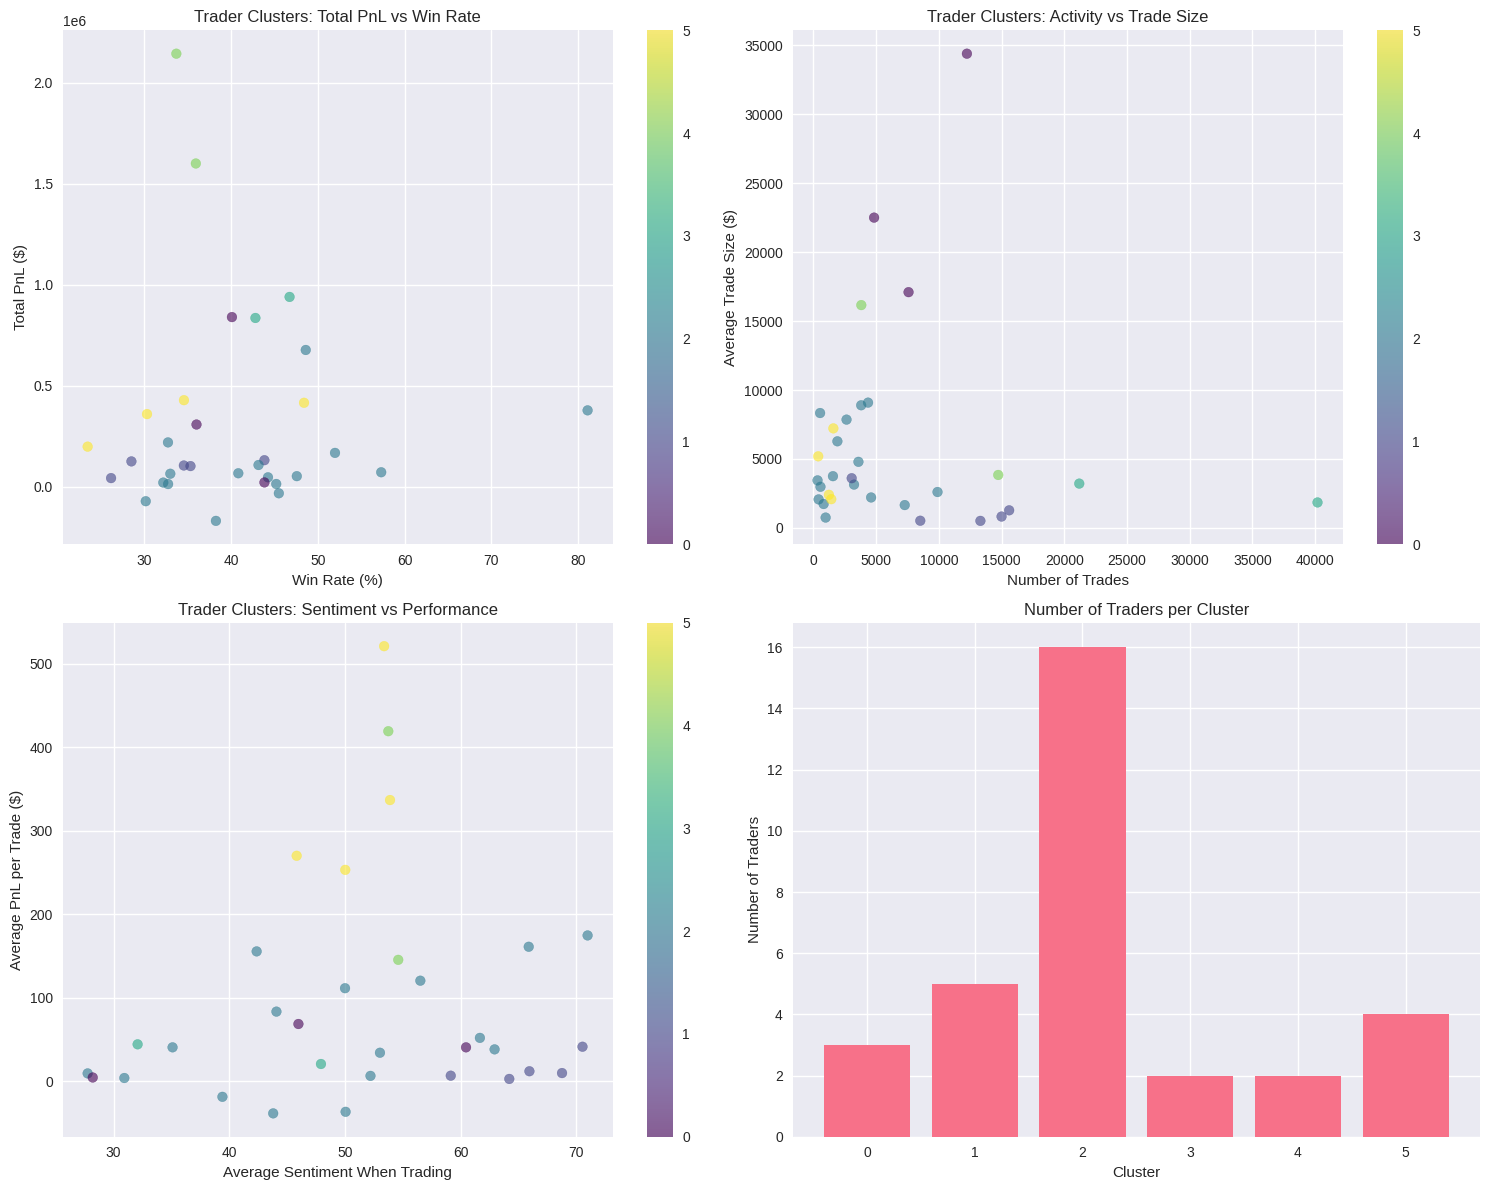

In [73]:
# 5. TRADER CLUSTERING AND BEHAVIOR ANALYSIS
# =============================================================================

def analyze_trader_behavior(merged_data):
    """Analyze individual trader behavior and cluster analysis"""

    print("\n" + "="*60)
    print("👥 TRADER BEHAVIOR AND CLUSTERING ANALYSIS")
    print("="*60)

    # Aggregate trader metrics
    trader_metrics = merged_data.groupby('Account').agg({
        'Closed PnL': ['sum', 'mean', 'count', 'std'],
        'Size USD': ['mean', 'sum'],
        'value': 'mean'  # Average sentiment when trading
    }).round(2)

    # Flatten column names
    trader_metrics.columns = ['_'.join(col).strip() for col in trader_metrics.columns]
    trader_metrics = trader_metrics.rename(columns={
        'Closed PnL_sum': 'Total_PnL',
        'Closed PnL_mean': 'Avg_PnL',
        'Closed PnL_count': 'Trade_Count',
        'Closed PnL_std': 'PnL_Volatility',
        'Size USD_mean': 'Avg_Trade_Size',
        'Size USD_sum': 'Total_Volume',
        'value_mean': 'Avg_Sentiment_When_Trading'
    })

    # Calculate additional metrics
    trader_metrics['Win_Rate'] = merged_data.groupby('Account').apply(
        lambda x: (x['Closed PnL'] > 0).mean() * 100
    )
    trader_metrics['Profit_Factor'] = trader_metrics.apply(
        lambda row: abs(row['Total_PnL'] / (row['PnL_Volatility'] * np.sqrt(row['Trade_Count'])))
        if row['PnL_Volatility'] > 0 else 0, axis=1
    )

    print(f"📊 Top 10 Traders by Total PnL:")
    print(trader_metrics.nlargest(10, 'Total_PnL')[['Total_PnL', 'Avg_PnL', 'Trade_Count', 'Win_Rate']])

    # Prepare data for clustering
    features_for_clustering = ['Total_PnL', 'Avg_PnL', 'Trade_Count', 'Win_Rate',
                              'Avg_Trade_Size', 'Avg_Sentiment_When_Trading']

    clustering_data = trader_metrics[features_for_clustering].fillna(0)

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_data)

    # Determine optimal number of clusters
    silhouette_scores = []
    K_range = range(2, 8)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(scaled_features)
        silhouette_avg = silhouette_score(scaled_features, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"\n🎯 Optimal number of clusters: {optimal_k}")

    # Perform clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    trader_metrics['Cluster'] = kmeans.fit_predict(scaled_features)

    # Analyze clusters
    cluster_analysis = trader_metrics.groupby('Cluster').agg({
        'Total_PnL': ['mean', 'count'],
        'Avg_PnL': 'mean',
        'Trade_Count': 'mean',
        'Win_Rate': 'mean',
        'Avg_Trade_Size': 'mean',
        'Avg_Sentiment_When_Trading': 'mean'
    }).round(2)

    print(f"\n📊 Cluster Analysis:")
    print(cluster_analysis)

    # Visualize clusters
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Total PnL vs Win Rate (colored by cluster)
    scatter = axes[0, 0].scatter(trader_metrics['Win_Rate'], trader_metrics['Total_PnL'],
                                c=trader_metrics['Cluster'], cmap='viridis', alpha=0.6)
    axes[0, 0].set_xlabel('Win Rate (%)')
    axes[0, 0].set_ylabel('Total PnL ($)')
    axes[0, 0].set_title('Trader Clusters: Total PnL vs Win Rate')
    plt.colorbar(scatter, ax=axes[0, 0])

    # 2. Average Trade Size vs Trade Count
    scatter2 = axes[0, 1].scatter(trader_metrics['Trade_Count'], trader_metrics['Avg_Trade_Size'],
                                 c=trader_metrics['Cluster'], cmap='viridis', alpha=0.6)
    axes[0, 1].set_xlabel('Number of Trades')
    axes[0, 1].set_ylabel('Average Trade Size ($)')
    axes[0, 1].set_title('Trader Clusters: Activity vs Trade Size')
    plt.colorbar(scatter2, ax=axes[0, 1])

    # 3. Sentiment vs Performance
    scatter3 = axes[1, 0].scatter(trader_metrics['Avg_Sentiment_When_Trading'], trader_metrics['Avg_PnL'],
                                 c=trader_metrics['Cluster'], cmap='viridis', alpha=0.6)
    axes[1, 0].set_xlabel('Average Sentiment When Trading')
    axes[1, 0].set_ylabel('Average PnL per Trade ($)')
    axes[1, 0].set_title('Trader Clusters: Sentiment vs Performance')
    plt.colorbar(scatter3, ax=axes[1, 0])

    # 4. Cluster sizes
    cluster_counts = trader_metrics['Cluster'].value_counts().sort_index()
    axes[1, 1].bar(cluster_counts.index, cluster_counts.values)
    axes[1, 1].set_xlabel('Cluster')
    axes[1, 1].set_ylabel('Number of Traders')
    axes[1, 1].set_title('Number of Traders per Cluster')

    plt.tight_layout()
    plt.show()

    return trader_metrics, cluster_analysis
trader_metrics, cluster_analysis = analyze_trader_behavior(merged_data)


⏰ TEMPORAL PATTERN ANALYSIS
📊 Most Profitable Hours:
      Hourly_Total_PnL  Hourly_Avg_PnL  Hourly_Trade_Count  Hourly_Avg_Size
Hour                                                                       
12           911657.26          131.17                6950          3100.36
7            712784.33           83.03                8585          4631.27
19           705423.69           55.86               12628          5777.69
20           632875.06           49.71               12731          5204.17
1            523198.63           49.92               10481          7757.95


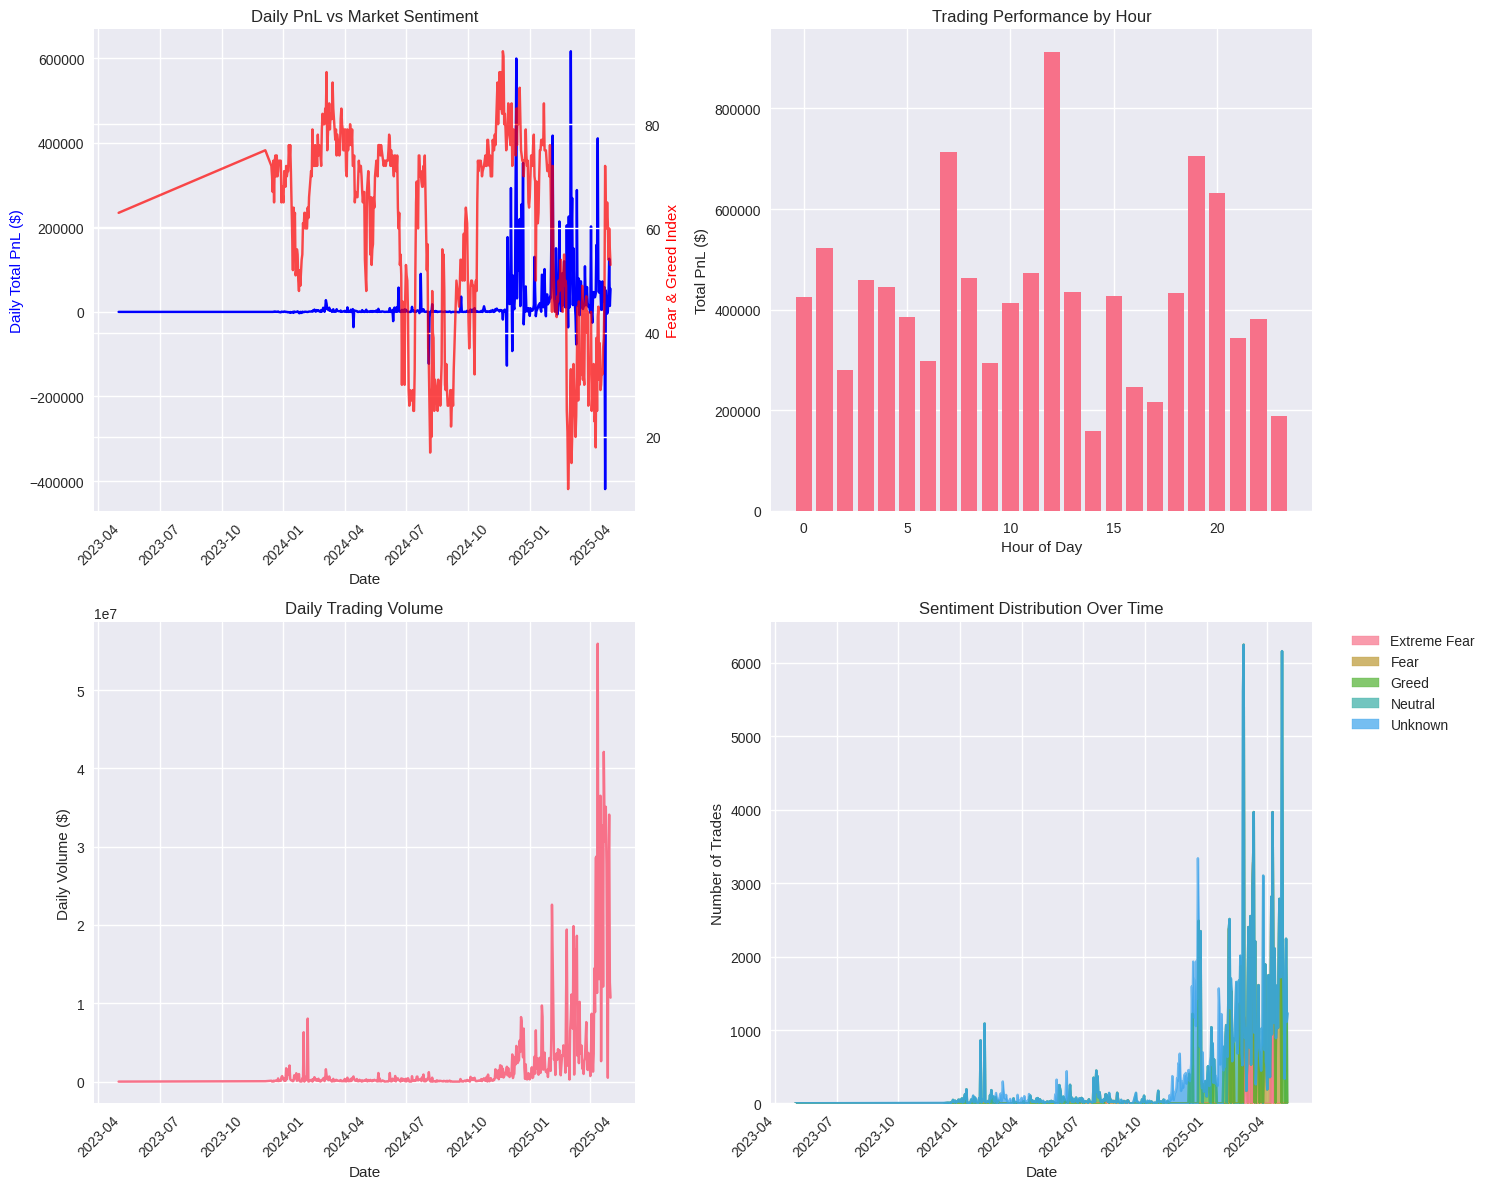

In [74]:
# 6. TIME-BASED ANALYSIS
# =============================================================================

def analyze_temporal_patterns(merged_data):
    """Analyze temporal patterns in trading and sentiment"""

    print("\n" + "="*60)
    print("⏰ TEMPORAL PATTERN ANALYSIS")
    print("="*60)

    # Daily performance
    daily_performance = merged_data.groupby('Date').agg({
        'Closed PnL': ['sum', 'mean', 'count'],
        'value': 'mean',
        'Size USD': 'sum'
    }).round(2)

    daily_performance.columns = ['Daily_Total_PnL', 'Daily_Avg_PnL', 'Daily_Trade_Count',
                               'Daily_Avg_Sentiment', 'Daily_Volume']

    # Hourly patterns
    hourly_performance = merged_data.groupby('Hour').agg({
        'Closed PnL': ['sum', 'mean', 'count'],
        'Size USD': 'mean'
    }).round(2)

    hourly_performance.columns = ['Hourly_Total_PnL', 'Hourly_Avg_PnL',
                                'Hourly_Trade_Count', 'Hourly_Avg_Size']

    print("📊 Most Profitable Hours:")
    print(hourly_performance.nlargest(5, 'Hourly_Total_PnL'))

    # Create temporal visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Daily PnL and Sentiment
    ax1 = axes[0, 0]
    ax2 = ax1.twinx()

    ax1.plot(daily_performance.index, daily_performance['Daily_Total_PnL'],
             color='blue', label='Daily PnL')
    ax2.plot(daily_performance.index, daily_performance['Daily_Avg_Sentiment'],
             color='red', alpha=0.7, label='Sentiment')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Total PnL ($)', color='blue')
    ax2.set_ylabel('Fear & Greed Index', color='red')
    ax1.set_title('Daily PnL vs Market Sentiment')
    ax1.tick_params(axis='x', rotation=45)

    # 2. Hourly trading patterns
    axes[0, 1].bar(hourly_performance.index, hourly_performance['Hourly_Total_PnL'])
    axes[0, 1].set_xlabel('Hour of Day')
    axes[0, 1].set_ylabel('Total PnL ($)')
    axes[0, 1].set_title('Trading Performance by Hour')

    # 3. Daily trade volume
    axes[1, 0].plot(daily_performance.index, daily_performance['Daily_Volume'])
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Daily Volume ($)')
    axes[1, 0].set_title('Daily Trading Volume')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Sentiment distribution over time
    sentiment_over_time = merged_data.groupby(['Date', 'Sentiment_Category']).size().unstack(fill_value=0)
    sentiment_over_time.plot(kind='area', stacked=True, ax=axes[1, 1], alpha=0.7)
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Number of Trades')
    axes[1, 1].set_title('Sentiment Distribution Over Time')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    return daily_performance, hourly_performance
daily_performance, hourly_performance = analyze_temporal_patterns(merged_data)

In [75]:
# 7. STATISTICAL SIGNIFICANCE TESTING
# =============================================================================

def statistical_testing(merged_data):
    """Perform statistical tests to validate findings"""

    print("\n" + "="*60)
    print("📊 STATISTICAL SIGNIFICANCE TESTING")
    print("="*60)

    # Test 1: Correlation between sentiment and PnL
    sentiment_pnl_corr, sentiment_pnl_p = pearsonr(merged_data['value'], merged_data['Closed PnL'])
    print(f"📈 Sentiment-PnL Correlation: {sentiment_pnl_corr:.4f} (p-value: {sentiment_pnl_p:.4f})")

    # Test 2: ANOVA - PnL differences across sentiment categories
    from scipy.stats import f_oneway

    sentiment_groups = []
    for sentiment in merged_data['Sentiment_Category'].unique():
        group_data = merged_data[merged_data['Sentiment_Category'] == sentiment]['Closed PnL']
        sentiment_groups.append(group_data)

    f_stat, f_p_value = f_oneway(*sentiment_groups)
    print(f"📊 ANOVA F-statistic: {f_stat:.4f} (p-value: {f_p_value:.4f})")

    # Test 3: T-tests between extreme sentiment periods
    extreme_fear = merged_data[merged_data['Sentiment_Category'] == 'Extreme Fear']['Closed PnL']
    greed = merged_data[merged_data['Sentiment_Category'] == 'Greed']['Closed PnL']

    if len(extreme_fear) > 0 and len(greed) > 0:
        t_stat, t_p_value = stats.ttest_ind(extreme_fear, greed)
        print(f"🔥 Extreme Fear vs Greed T-test: {t_stat:.4f} (p-value: {t_p_value:.4f})")

    # Effect sizes
    def cohens_d(group1, group2):
        n1, n2 = len(group1), len(group2)
        pooled_std = np.sqrt(((n1-1)*group1.var() + (n2-1)*group2.var()) / (n1+n2-2))
        return (group1.mean() - group2.mean()) / pooled_std

    if len(extreme_fear) > 0 and len(greed) > 0:
        effect_size = cohens_d(extreme_fear, greed)
        print(f"📏 Effect Size (Cohen's d): {effect_size:.4f}")

    # Significance interpretation
    print(f"\n🔍 INTERPRETATION:")
    if sentiment_pnl_p < 0.05:
        print(f"✅ Significant correlation between sentiment and PnL detected")
    else:
        print(f"❌ No significant correlation between sentiment and PnL")

    if f_p_value < 0.05:
        print(f"✅ Significant differences in PnL across sentiment categories")
    else:
        print(f"❌ No significant differences in PnL across sentiment categories")
statistical_testing(merged_data)


📊 STATISTICAL SIGNIFICANCE TESTING
📈 Sentiment-PnL Correlation: 0.0081 (p-value: 0.0002)
📊 ANOVA F-statistic: 9.0622 (p-value: 0.0000)
🔥 Extreme Fear vs Greed T-test: -0.8961 (p-value: 0.3702)
📏 Effect Size (Cohen's d): -0.0073

🔍 INTERPRETATION:
✅ Significant correlation between sentiment and PnL detected
✅ Significant differences in PnL across sentiment categories


In [76]:
# 8. TRADING STRATEGY RECOMMENDATIONS
# =============================================================================

def generate_strategy_recommendations(merged_data, trader_metrics, sentiment_performance):
    """Generate actionable trading strategy recommendations"""

    print("\n" + "="*60)
    print("💡 TRADING STRATEGY RECOMMENDATIONS")
    print("="*60)

    # Key insights
    best_sentiment = sentiment_performance['Closed PnL']['mean'].idxmax()
    worst_sentiment = sentiment_performance['Closed PnL']['mean'].idxmin()

    avg_pnl_by_sentiment = merged_data.groupby('Sentiment_Category')['Closed PnL'].mean()

    print(f"🎯 KEY INSIGHTS:")
    print(f"   • Best performing sentiment: {best_sentiment}")
    print(f"   • Worst performing sentiment: {worst_sentiment}")
    print(f"   • Average PnL difference: ${avg_pnl_by_sentiment.max() - avg_pnl_by_sentiment.min():.2f}")

    # Top trader characteristics
    top_traders = trader_metrics.nlargest(10, 'Total_PnL')
    top_trader_avg_sentiment = top_traders['Avg_Sentiment_When_Trading'].mean()

    print(f"\n🏆 TOP TRADER CHARACTERISTICS:")
    print(f"   • Average sentiment when trading: {top_trader_avg_sentiment:.1f}")
    print(f"   • Average win rate: {top_traders['Win_Rate'].mean():.1f}%")
    print(f"   • Average trade count: {top_traders['Trade_Count'].mean():.0f}")

    # Strategy recommendations
    strategies = [
        {
            "name": "Sentiment Contrarian Strategy",
            "description": f"Trade opposite to extreme sentiment. Data shows {'higher' if avg_pnl_by_sentiment['Extreme Fear'] > avg_pnl_by_sentiment['Greed'] else 'lower'} performance during extreme fear.",
            "implementation": "Enter long positions during extreme fear periods, short during extreme greed."
        },
        {
            "name": "Optimal Timing Strategy",
            "description": "Focus trading during high-performance hours and sentiment conditions.",
            "implementation": f"Concentrate trading when sentiment is {best_sentiment.lower()} for optimal results."
        },
        {
            "name": "Risk Management by Sentiment",
            "description": "Adjust position sizes based on market sentiment volatility.",
            "implementation": "Reduce position sizes during extreme sentiment periods, increase during neutral conditions."
        },
        {
            "name": "Cluster-Based Approach",
            "description": "Adopt successful trader cluster characteristics.",
            "implementation": f"Maintain average sentiment exposure around {top_trader_avg_sentiment:.0f} like top performers."
        }
    ]

    print(f"\n📋 RECOMMENDED STRATEGIES:")
    for i, strategy in enumerate(strategies, 1):
        print(f"\n{i}. {strategy['name']}")
        print(f"   Description: {strategy['description']}")
        print(f"   Implementation: {strategy['implementation']}")

    # Risk warnings
    print(f"\n⚠️  RISK CONSIDERATIONS:")
    print(f"   • Past performance doesn't guarantee future results")
    print(f"   • Market conditions can change rapidly")
    print(f"   • Always use proper risk management")
    print(f"   • Consider transaction costs and slippage")

    return strategies


In [77]:
generate_strategy_recommendations(merged_data, trader_metrics, sentiment_performance)


💡 TRADING STRATEGY RECOMMENDATIONS
🎯 KEY INSIGHTS:
   • Best performing sentiment: Unknown
   • Worst performing sentiment: Neutral
   • Average PnL difference: $33.59

🏆 TOP TRADER CHARACTERISTICS:
   • Average sentiment when trading: 48.9
   • Average win rate: 44.2%
   • Average trade count: 11066

📋 RECOMMENDED STRATEGIES:

1. Sentiment Contrarian Strategy
   Description: Trade opposite to extreme sentiment. Data shows lower performance during extreme fear.
   Implementation: Enter long positions during extreme fear periods, short during extreme greed.

2. Optimal Timing Strategy
   Description: Focus trading during high-performance hours and sentiment conditions.
   Implementation: Concentrate trading when sentiment is unknown for optimal results.

3. Risk Management by Sentiment
   Description: Adjust position sizes based on market sentiment volatility.
   Implementation: Reduce position sizes during extreme sentiment periods, increase during neutral conditions.

4. Cluster-Base

[{'name': 'Sentiment Contrarian Strategy',
  'description': 'Trade opposite to extreme sentiment. Data shows lower performance during extreme fear.',
  'implementation': 'Enter long positions during extreme fear periods, short during extreme greed.'},
 {'name': 'Optimal Timing Strategy',
  'description': 'Focus trading during high-performance hours and sentiment conditions.',
  'implementation': 'Concentrate trading when sentiment is unknown for optimal results.'},
 {'name': 'Risk Management by Sentiment',
  'description': 'Adjust position sizes based on market sentiment volatility.',
  'implementation': 'Reduce position sizes during extreme sentiment periods, increase during neutral conditions.'},
 {'name': 'Cluster-Based Approach',
  'description': 'Adopt successful trader cluster characteristics.',
  'implementation': 'Maintain average sentiment exposure around 49 like top performers.'}]